# Vision Tarea 12: Puntos Esquina de Harris.

### Hacer la implementación para determinar los puntos esquina de Harris. Reportar:
#### Daniel Castro Pineda 2220220H

In [165]:
import numpy as np
# from time import perf_counter
import cv2
import matplotlib.pyplot as plt
import numba as nb
import urllib.request


In [166]:
req = urllib.request.urlopen(
    'https://m.media-amazon.com/images/I/91WtBbqm6JL._AC_SX425_.jpg')

arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img = cv2.imdecode(arr, -1)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


In [167]:

def GKernel(sigma):
  m = int(np.floor(3*sigma + 0.5))
  N = int(2*m+1)
  g = np.zeros(N)

  suma = 0
  for n in range(1, m+1):
    g[m+n] = np.exp(- n**2 / (2*sigma**2))
    suma += g[m+n]

  suma = 1 + 2*suma

  for n in range(1, m+1):
    g[m+n] /= suma
    g[m-n] = g[m+n]
  g[m] = 1/suma

  return g


def GDerivadasKernel(sigma=1, orden=0):
  """ 
  Args:
  simga int , orden 1-7
  Retorna: gausiana por n orden de derivada 
   """
  if orden >= 0 and orden < 7:
    g = GKernel(sigma)
    gz = g.size
    mu = int(np.floor(3*sigma + 0.5))
    a = np.zeros(g.size)
    if (orden == 0):
      return g
    if (orden == 1):
      return [g[x]*(mu - x)/sigma**2 for x in range(gz)]
    if (orden == 2):
      return [g[x]*(((mu-x)**2 - sigma ** 2)/sigma**4) for x in range(gz)]
    if (orden == 3):
      return [g[x]*(3*sigma**2*(x - mu) - (x - mu)**3)/sigma**6 for x in range(gz)]
    if (orden == 4):
      return [g[x]*(3*sigma**4 - 6*sigma**2*(x - mu)**2 + (x - mu)**4)/sigma**8 for x in range(gz)]
    if (orden == 5):
      return [g[x]*(10*sigma**2*(x - mu)**3 + 15*sigma**4*(mu - x) - (x - mu)**5)/sigma**10 for x in range(gz)]
    if (orden == 6):
      return [g[x]*(-15*sigma**6 - 15*sigma**2*(x - mu)**4 + 45*sigma**4*(x - mu) + (x - mu)**6)/sigma**12 for x in range(gz)]
  else:
    raise Exception("Ingresar orden 1-7")


def convolveDesacopladaDot(img, kernelx, kernely):

    if(kernelx.size != kernely.size):
      raise Exception("Kernels deben ser del mismo tamaño")

    kernelx = np.flip(kernelx)
    kernely = np.flip(kernely)

    nrows, ncols = img.shape
    k_size = kernelx.size
    # krows, kcols = kernel.shape
    pad_size = (k_size - 1) // 2
    padded_img = np.pad(img, pad_size, mode='constant')
    # print(padded_img)
    output = np.zeros((nrows, ncols))

    output = np.array([convolveDot(img[i, :], kernelx) for i in range(nrows)])

    # print(output)
    output2 = np.zeros((nrows, ncols))
    output2 = np.array([convolveDot(output[:, j], kernely)
                       for j in range(ncols)]).T
    return output2


def convolveDot(signal, kernel):
    ker_size = kernel.size
    sig_size = signal.size
    # kernel = kernel[::-1]
    pad_size = (ker_size - 1) // 2
    padded_signal = np.pad(signal, pad_size, mode='constant')
    output = np.zeros(sig_size)
    output = [np.dot(padded_signal[k:k+ker_size], kernel)
              for k in range(sig_size)]

    return output


def caja(intImg, r, c, n, m):
    N = 2*n+1
    M = 2*m+1
    pad = (N - 1) // 2

    nrows, ncols = intImg.shape

    r0 = r - pad
    c0 = c - pad
    r1 = r + pad
    c1 = c + pad

    if r1 >= nrows:
        r1 = nrows - 1
    if c1 >= ncols:
        c1 = ncols - 1

    s0 = intImg[r1, c1]
    s1 = 0
    s2 = 0
    s3 = 0

    if r0 > 0:
        s1 = intImg[r0-1, c1]
    if c0 > 0:
        s2 = intImg[r1, c0-1]
    if r0 > 0 and c0 > 0:
        s3 = intImg[r0-1, c0-1]
    out = s0 - s1 - s2 + s3
    return out/(N)


def integralImg(img):
    nr = img.shape[0]
    nc = img.shape[1]
    intImg = np.zeros((nr, nc))

    a = np.array([np.cumsum(img[:, j]) for j in range(nc)]).T
    b = np.array([np.cumsum(a[i, :]) for i in range(nr)])
    intImg = b
    return intImg


def derivaintegral(img, tamCaja, dir='x'):

    intimg = integralImg(img)
    nr, nc = img.shape
    out = np.zeros((nr, nc), dtype=np.float64)

    if dir == 'x':
        out = np.array([[
            caja(intimg, r, c+tamCaja, tamCaja, tamCaja) -
            caja(intimg, r, c-tamCaja, tamCaja, tamCaja)
            for c in range(nc)]
            for r in range(nr)
        ])

    if dir == 'y':
        out = np.array([[
            caja(intimg, r+tamCaja, c, tamCaja, tamCaja) -
            caja(intimg, r-tamCaja, c, tamCaja, tamCaja)
            for c in range(nc)]
            for r in range(nr)
        ])
    return out


## a) La implementación de una función utilizando derivadas de Gaussiana. La función recibirá una imagen en tono de gris, los umbrales para tal objetivo y el valor de la varianza de las gaussianas.

In [168]:
def puntosEsquinaGaussiana(img, sigma, tau, h):
    harris = np.zeros(img.shape)

    d0 = np.array(GDerivadasKernel(sigma, 0))
    d1 = np.array(GDerivadasKernel(sigma, 1))
    
    ix = convolveDesacopladaDot(img, d1, d0)
    iy = convolveDesacopladaDot(img, d0, d1)
    ixx = ix**2
    iyy = iy**2
    ixy = ix*iy
    
    ixy = ix*iy
    ixx = np.square(ix)
    iyy = np.square(iy)

    ixx = convolveDesacopladaDot(ixx, d0, d0)
    iyy = convolveDesacopladaDot(iyy, d0, d0)
    ixy = convolveDesacopladaDot(ixy, d0, d0)
    
    
    p = P(ixx, iyy, ixy, tau)
    harris = np.where(p >= h, p,0)
    return harris
    
        

def P(A,B,C, TAU):
    det = A*B - C**2
    traza = TAU*(A+B)**2
    return det - traza


## b) La implementación de una función utilizando derivadas con imágenes integrales. La función recibirá una imagen en tono de gris, los umbrales para tal objetivo y el valor del tamaño de la caja utilizada,

In [169]:
def puntosEsquinaIntegral(img, cajita, tau, h):

    harrisIntegral = np.zeros(img.shape)

    kernel = np.ones(2*cajita+1)/(2*cajita+1)

    ix = derivaintegral(img, cajita, 'x')
    iy = derivaintegral(img, cajita, 'y')

    ixy = ix*iy
    ixx = np.square(ix)
    iyy = np.square(iy)
    ixx = convolveDesacopladaDot(ixx, kernel, kernel)
    iyy = convolveDesacopladaDot(iyy, kernel, kernel)
    ixy = convolveDesacopladaDot(ixy, kernel, kernel)

    p = P(ixx, iyy, ixy, tau)
    harrisIntegral = np.where(p >= h,p,0)
    
    return harrisIntegral


### c) Mostrar los resultados comparativos para la imagen dada. Mostrar la imagen los puntos esquina con derivadas de Gaussianas y las derivadas con imágenes integrales. Considerar que la varianza es sigma = 0.7 y el tamaño de la caja es 3x3.

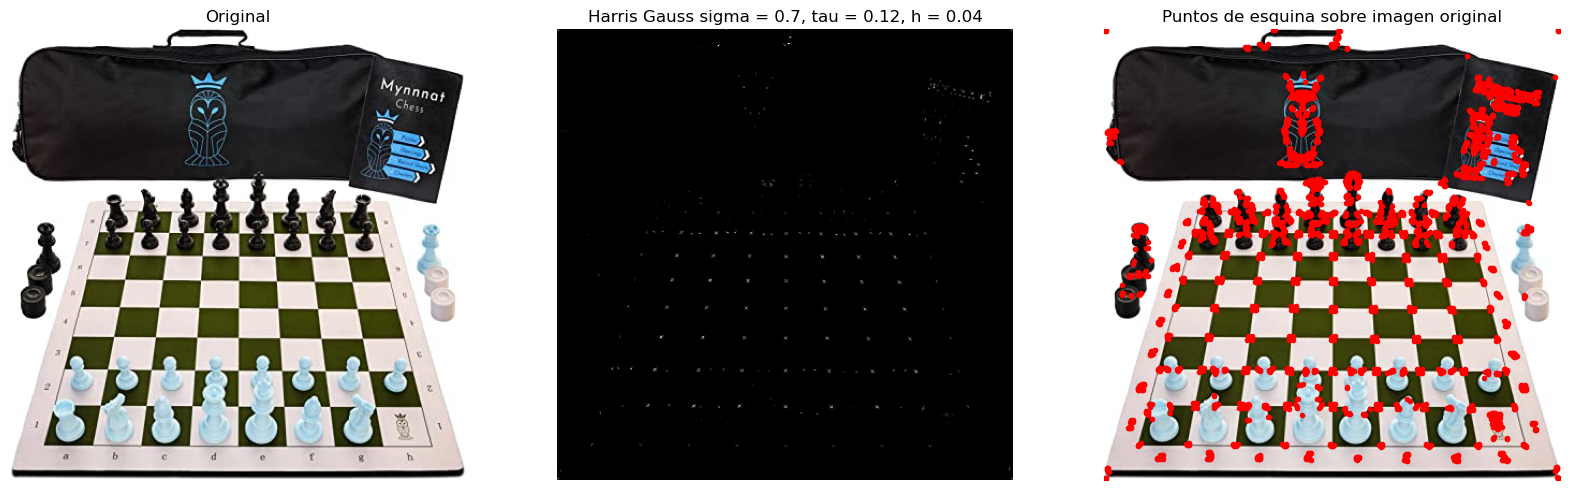

In [170]:
harrisGauss = puntosEsquinaGaussiana(gray, 0.7,0.12, 0.04)
harrisGauss = cv2.normalize(harrisGauss, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

plt.figure(figsize=(20, 20))

plt.subplot(1,3,1)
plt.title('Original')
plt.imshow(img, cmap='gray')
plt.axis('off')
# plt.show()

plt.subplot(1, 3, 2)
plt.title('Harris Gauss sigma = 0.7, tau = 0.12, h = 0.04')
plt.imshow(harrisGauss, cmap='gray')
plt.axis('off')
# plt.show()

plt.subplot(1,3,3)
plt.imshow(img, cmap='gray')
plt.title('Puntos de esquina sobre imagen original')
plt.plot(np.where(harrisGauss>0)[1], np.where(harrisGauss>0)[0], 'r.')
plt.axis('off')
plt.show()

/var/folders/hs/q_d_445d1x1173_zp50_lv3w0000gn/T/ipykernel_5585/2262805528.py:116: RuntimeWarning: overflow encountered in ulong_scalars
  out = s0 - s1 - s2 + s3


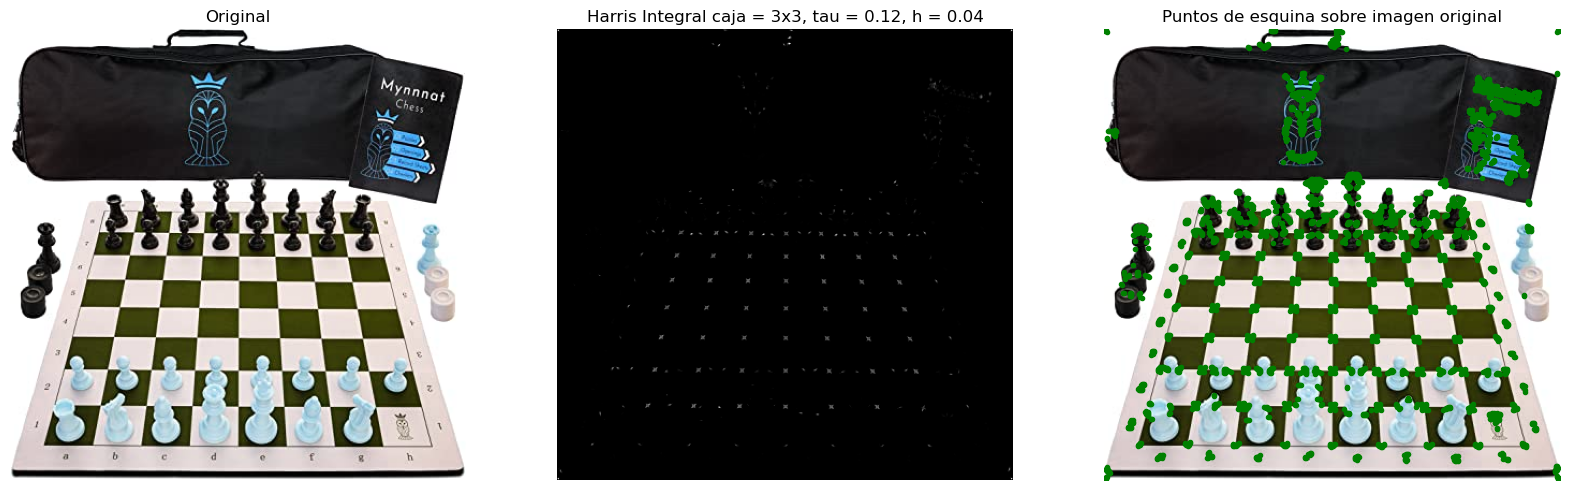

In [171]:
harrisIntegral = puntosEsquinaIntegral(gray, 1, 0.12,0.85)
harrisIntegral = cv2.normalize(harrisIntegral, None, alpha=0,
                            beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)


plt.figure(figsize=(20, 20))

plt.subplot(1, 3, 1)
plt.title('Original')
plt.imshow(img, cmap='gray')
plt.axis('off')
# plt.show()

plt.subplot(1, 3, 2)
plt.title('Harris Integral caja = 3x3, tau = 0.12, h = 0.04')
plt.imshow(harrisIntegral, cmap='gray')
plt.axis('off')
# plt.show()

plt.subplot(1, 3, 3)
plt.imshow(img, cmap='gray')
plt.title('Puntos de esquina sobre imagen original')
plt.plot(np.where(harrisIntegral > 0)[1],
         np.where(harrisIntegral > 0)[0], 'g.')
plt.axis('off')
plt.show()


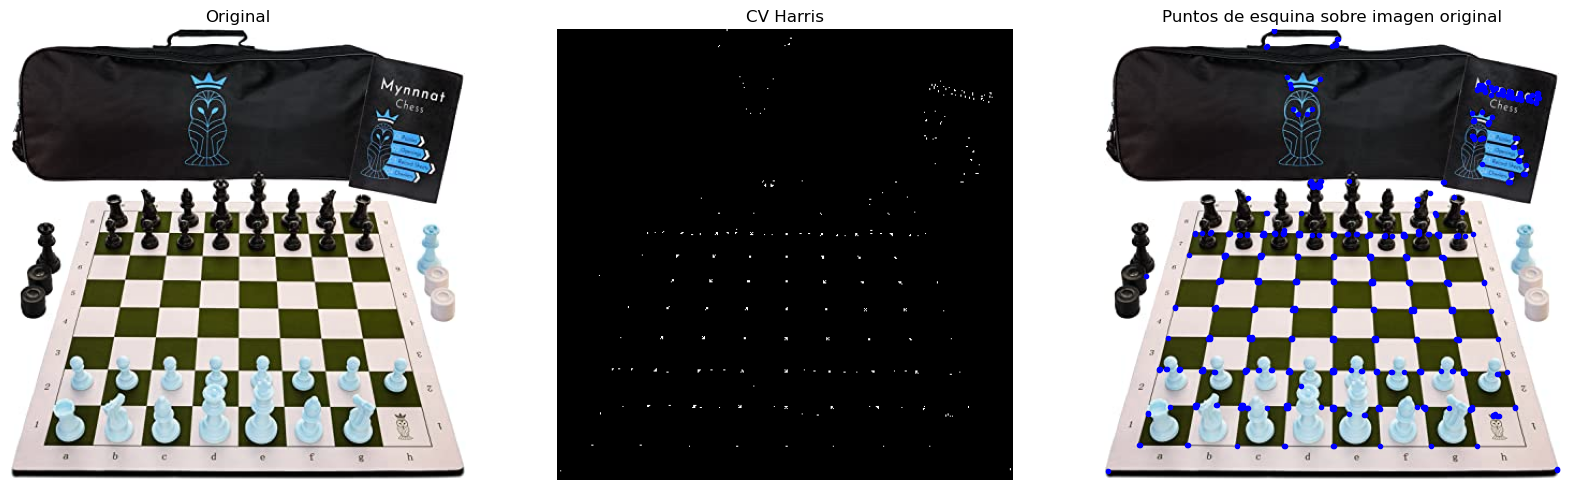

In [172]:
harriscv = cv2.cornerHarris(gray, 2,3, 0.12)

test = np.zeros(gray.shape)
test[harriscv>0.0049]=255

plt.figure(figsize=(20, 20))

plt.subplot(1, 3, 1)
plt.title('Original')
plt.imshow(img, cmap='gray')
plt.axis('off')
# plt.show()

plt.subplot(1, 3, 2)
plt.title('CV Harris')
plt.imshow(test, cmap='gray')
plt.axis('off')
# plt.show()

plt.subplot(1, 3, 3)
plt.imshow(img, cmap='gray')
plt.title('Puntos de esquina sobre imagen original')
plt.plot(np.where(test > 0)[1],
         np.where(test > 0)[0], 'b.')
plt.axis('off')
plt.show()


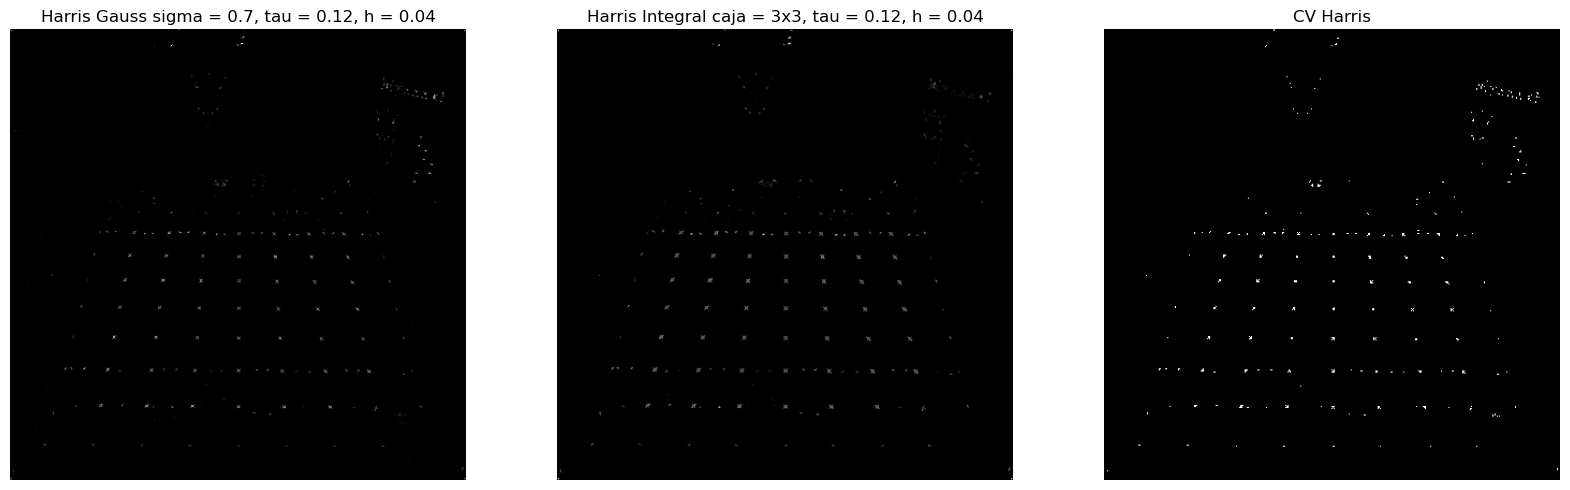

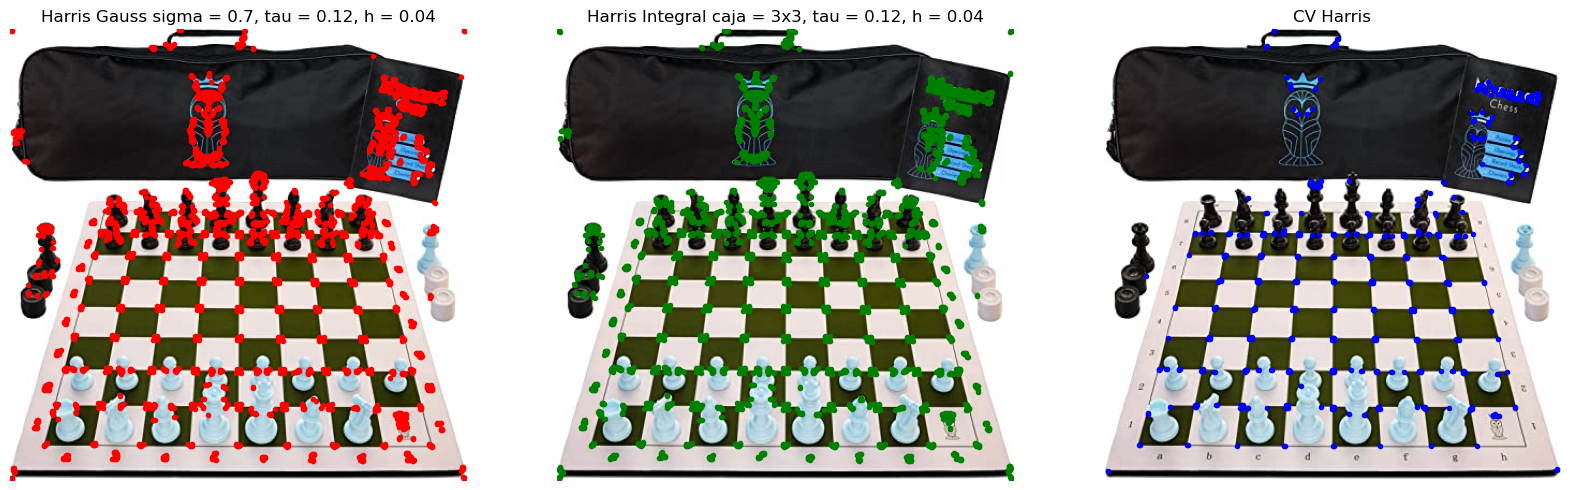

In [173]:
plt.figure(figsize=(20, 20))

plt.subplot(1, 3, 1)
plt.title('Harris Gauss sigma = 0.7, tau = 0.12, h = 0.04')
plt.imshow(harrisGauss, cmap='gray')

plt.axis('off')
# plt.show()

plt.subplot(1, 3, 2)
plt.title('Harris Integral caja = 3x3, tau = 0.12, h = 0.04')
plt.imshow(harrisIntegral, cmap='gray')
plt.axis('off')
# plt.show()

plt.subplot(1, 3, 3)
plt.title('CV Harris')
plt.imshow(test, cmap='gray')
plt.axis('off')
plt.show()


plt.figure(figsize=(20, 20))
plt.subplot(1, 3, 1)
plt.title('Harris Gauss sigma = 0.7, tau = 0.12, h = 0.04')
plt.imshow(img, cmap='gray')
plt.plot(np.where(harrisGauss > 0)[1], np.where(harrisGauss > 0)[0], 'r.')

plt.axis('off')
# plt.show()

plt.subplot(1, 3, 2)
plt.title('Harris Integral caja = 3x3, tau = 0.12, h = 0.04')
plt.imshow(img, cmap='gray')
plt.plot(np.where(harrisIntegral > 0)[1],
         np.where(harrisIntegral > 0)[0], 'g.')
plt.axis('off')
# plt.show()

plt.subplot(1, 3, 3)
plt.title('CV Harris')

plt.imshow(img, cmap='gray')
plt.plot(np.where(test > 0)[1],
         np.where(test > 0)[0], 'b.')
plt.axis('off')
plt.show()


